In [9]:
import numpy as np
import jax.numpy as jnp
import jax
import optax
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from jax.nn.initializers import *

from tn4ml.initializers import *
from tn4ml.models.smpo import *
from tn4ml.models.model import *
from tn4ml.embeddings import *
from tn4ml.loss import *
from tn4ml.strategy import *
from tn4ml.util import *

### Load dataset

In [10]:
train, test = mnist.load_data()

In [11]:
data = {"X": dict(train=train[0], test=test[0]), "y": dict(train=train[1], test=test[1])}

***Reduce the size of the image*** - for faster inference

In [12]:
strides = (4,4) # (2,2) for 14x14 images; (4,4) for 7x7 images
pool_size = (2,2)
pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides, padding="same")

In [13]:
X_pooled = pool(tf.constant(data['X']['train'].reshape(-1,28,28,1))).numpy().reshape(-1,7,7)/255.0
X_pooled_test = pool(tf.constant(data['X']['test'].reshape(-1,28,28,1))).numpy().reshape(-1,7,7)/255.0

***Rearagne pixels in zig-zag order***  
To deal better with correlations between neighbouring pixels.

In [14]:
train_data = zigzag_order(X_pooled)
test_data = zigzag_order(X_pooled_test)

In [15]:
n_classes = 10

In [16]:
y_train = integer_to_one_hot(data['y']['train'], n_classes)
y_test = integer_to_one_hot(data['y']['test'], n_classes)

***Take samples for training, validation and testing***

In [17]:
train_size = 6000
test_size = 10000
val_perc = 0.2

In [18]:
# take val_size samples from normal class for validation (X% of training data)
val_size = int(val_perc*train_size)
train_size = int(train_size - val_size)

In [19]:
indices = list(range(len(train_data)))
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size : train_size+val_size]

# train data and validation inputs
train_inputs = np.take(train_data, train_indices, axis=0)
val_inputs = np.take(train_data, val_indices, axis=0)


# train data and validation labels
train_targets = np.take(y_train, train_indices, axis=0)
val_targets = np.take(y_train, val_indices, axis=0)

In [20]:
indices = list(range(len(test_data)))
np.random.shuffle(indices)

test_indices = indices[:test_size]

# test inputs
test_inputs = np.take(test_data, test_indices, axis=0)

# test labels
test_targets = np.take(y_test, test_indices, axis=0)

**Training setup**  
$\rightarrow$ direct gradient descent

In [21]:
# model parameters
L = 49
initializer = identity_init('bond', 1e-1, dtype=jnp.float64)
#initializer = ones_init()
key = jax.random.key(42)
shape_method = 'even'
bond_dim = 10
phys_dim = (3, n_classes)
spacing = L
canonical_center=0

In [22]:
model = SMPO_initialize(L=L,
                        initializer=initializer,
                        key=key,
                        shape_method=shape_method,
                        spacing=spacing,
                        bond_dim=bond_dim,
                        phys_dim=phys_dim,
                        cyclic=False,
                        canonical_center=canonical_center)

***Train parameters***

In [23]:
optimizer = optax.adam
strategy = 'global'
loss = loss_wrapper_optax(optax.softmax_cross_entropy)
train_type ='supervised'
embedding = original_inverse(p=3)
#embedding = reduce_interaction()
learning_rate = 1e-3

# # Exponential decay of the learning rate.
# scheduler = optax.exponential_decay(
#     init_value=1e-3,
#     transition_steps=1000,
#     decay_rate=0.95)

# # Combining gradient transforms using `optax.chain`.
# gradient_transforms = [
#     optax.clip_by_global_norm(1.0),  # Clip by the gradient by the global norm.
#     optax.scale_by_adam(),  # Use the updates from adam.
#     optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
#     # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
#     optax.scale(-1.0)
# ]

In [24]:
model.configure(optimizer=optimizer, strategy=strategy, loss=loss, train_type=train_type, learning_rate=learning_rate)

In [25]:
epochs = 200
batch_size = 50

In [26]:
history = model.train(train_inputs,
                        targets = train_targets,
                        val_inputs = val_inputs,
                        val_targets = val_targets,
                        epochs = epochs,
                        batch_size = batch_size,
                        embedding = embedding,
                        normalize = True,
                        dtype = jnp.float64)

epoch: 100%|██████████| 200/200 [18:18<00:00,  5.49s/it, loss=1.568925387855228, val_loss=1.625948525905556]  


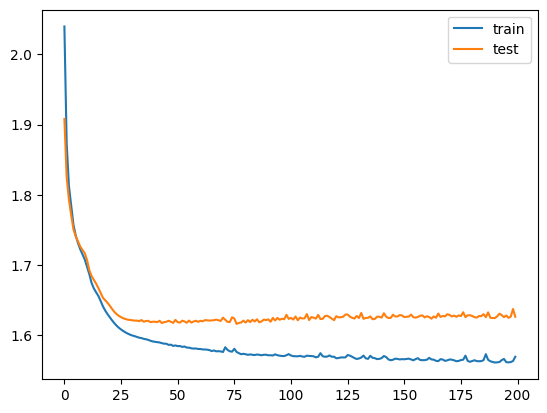

In [27]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(len(history['loss'])), history['loss'], label='train')
plt.plot(range(len(history['val_loss'])), history['val_loss'], label='test')
plt.legend()
plt.savefig('tests/mnist_supervised_model6/loss.pdf')

In [28]:
# save the model
model.save('model', 'tests/mnist_supervised_model6')

### Evaluate

In [29]:
from tn4ml.models.model import _batch_iterator

In [30]:
batch_size = 64
correct_predictions = 0; total_loss = 0

for batch_data in _batch_iterator(test_inputs, test_targets, batch_size=batch_size):
    x, y = batch_data
    x = jnp.array(x, dtype=jnp.float64)
    y = jnp.array(y, dtype=jnp.float64)

    y_pred = jnp.squeeze(jnp.array(jax.vmap(model.predict, in_axes=(0, None, None))(x, embedding, False)[0]))
    predicted = jnp.argmax(y_pred, axis=-1)
    true = jnp.argmax(y, axis=-1)

    correct_predictions += jnp.sum(predicted == true).item() / batch_size

accuracy = correct_predictions / (len(test_targets)//batch_size)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8379407051282052
